# Classification problem with AUC score
## Pipeline

#### 1. Load the data
    
    - Get some insights about the data
    - Find and delete duplicated data and one value only columns 
    
#### 2. Data preprocessing
    
    - One hot encoding with counting
    - Count frequencies
    - One hot encoding for labels
    - Datetime encoder
    - Concatenate dataset
    - Find the most inforamtive features
    - Standardize data
    
#### 3. Model selection
    
    - Logistic regression
    - XGBoost
    - Adaboost
    - Decision trees
    
#### 4. Final result evaluating
    
    - AUC ROC
    

# Load the data 

In [56]:
# Import main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import interp
from xgboost import XGBClassifier


%matplotlib inline

np.random.seed(0)

### Insights about the data

In [49]:
data_df = pd.read_csv('classif_is_high_val.csv', na_values=['NA'])
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20105 entries, 0 to 20104
Data columns (total 26 columns):
id                        20105 non-null int64
fst_booking_type          20105 non-null int64
fst_booking_type0         4142 non-null float64
fst_subject               20105 non-null object
fst_tutor_type            20105 non-null object
fst_price_per_hour_USD    20105 non-null float64
fst_language              20105 non-null object
fst_country_code          11050 non-null object
fst_device_type           8991 non-null object
fst_source                20105 non-null object
fst_language2             20105 non-null object
fst_traffic_type          20105 non-null object
fst_l_created_d           20105 non-null object
fst_l_created_t           20105 non-null object
fst_joined                20105 non-null object
lst_req                   20105 non-null object
lst_buy                   20103 non-null object
lst_lsn                   12825 non-null object
lst_login                 201

In [50]:
data_df.describe()

,id,fst_booking_type,fst_booking_type0,fst_price_per_hour_USD,l_req_3d,l_req_3d_num_tutors,M_pay_3d,M_pay_13_3d,is_high_val,fst_tutor_id2
count,20105.000000,20105.000000,4142.000000,20105.000000,20105.000000,20105.000000,14276.000000,18925.000000,20105.000000,20105.000000
mean,10053.000000,2.355334,4.347175,9.436453,9.402537,9.402487,19.933939,44.049459,0.253071,1315.369261
std,5803.957917,1.526029,0.558304,4.524126,13.868817,13.868845,28.393400,45.951666,0.434782,851.976901
min,1.000000,1.000000,1.000000,2.034884,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,5027.000000,1.000000,4.000000,6.000000,1.000000,1.000000,6.980000,10.000000,0.000000,544.000000
50%,10053.000000,1.000000,4.000000,9.000000,3.000000,3.000000,10.000000,26.660000,0.000000,1199.000000
75%,15079.000000,4.000000,5.000000,12.000000,13.000000,13.000000,18.000000,63.380000,1.000000,2053.000000
max,20105.000000,5.000000,5.000000,20.888889,193.000000,193.000000,270.060000,275.030000,1.000000,3000.000000


In [53]:
# Number of positive target values
number_pos = data_df[data_df['is_high_val'] == 1].shape[0]
number_all = data_df.shape[0]
print(f'Target labels of class \'1\': {number_pos} or {(number_pos/number_all)*100:.2f}% over all.')

Target labels of class '1': 5088 or 25.31% over all.


###  Duplicated and meaningless data 

In [51]:
# Find meaningless columns (<=1 categories)
for col in data_df.columns:
    if np.unique(data_df[col].dropna().astype(str)).shape[0] <= 1:
        print(col)

fst_subject
fst_tutor_type


In [54]:
# Drop meaningless columns
filtered_df = data_df.drop(labels=['id', 'fst_subject', 'fst_tutor_type'], axis=1)

## Data preprocessing 
### One-hot counting

In [57]:
# Because some booking types are presented twice in both columns, we need
# the one-hot encoding function, that counts number of times feature is presented
def one_hot_count(data, columns, name_prefix=None, default_type=np.float):
    unique_lbl = np.array([])
    # Find unique values in both columns to create resulting feature label vector
    for col in columns:
        unique_for_col = np.unique(data[col]).astype(default_type)
        unique_lbl = np.append(unique_lbl, unique_for_col)
    unique_lbl = np.unique(unique_lbl)
    
    if default_type == np.float:
        # Leave only not-nan values
        unique_lbl = unique_lbl[~np.isnan(unique_lbl)]
    
    # Zeros with the number of rows as in initial data 
    # and number of columns equal to unique value number
    encoded_columns = np.zeros((data.shape[0], unique_lbl.shape[0])) 
    # One hot encoding over each column
    for col in columns:
        column = data[col]
        for i in range(unique_lbl.shape[0]):
            encoded_columns[column == unique_lbl[i], i] += 1
    
    # Add prefix to column names
    if name_prefix:
        unique_lbl = map(lambda x: name_prefix + str(x), unique_lbl)
        unique_lbl = list(unique_lbl)
        
    return pd.DataFrame(encoded_columns, columns=unique_lbl)


booking_type_oh = one_hot_count(filtered_df, ['fst_booking_type', 'fst_booking_type0'], 'booking_type_')
language_oh = one_hot_count(filtered_df, ['fst_language', 'fst_language2'], 'fst_language_', default_type=str)

### Count frequencies

In [59]:
# Find frequencies of classes presented in dataset
def frequency_counter(column):
    
    unique_lbl = np.unique(column)
    frequecies = dict()
    for lbl in unique_lbl:
        frequecies[lbl] = column[column == lbl].shape[0]
    return frequecies    

frequency_counter(filtered_df['fst_device_type'].fillna('undefined'))

{'desktop': 6841, 'mobile': 1675, 'tablet': 475, 'undefined': 11114}

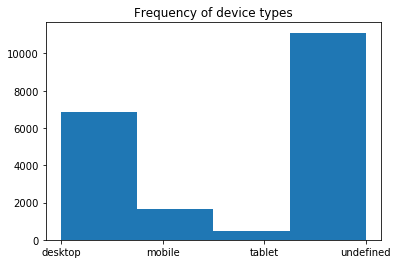

In [83]:
freq_le = LabelEncoder()
freq_encoded = freq_le.fit_transform(filtered_df['fst_device_type'].fillna('undefined'))
plt.hist(freq_encoded, bins=4)
plt.title('Frequency of device types')
plt.xticks(np.arange(4), freq_le.classes_)
plt.show()

### Onehot encoding for labels

In [84]:
# One-hot encoder pipeline for labels
def one_hot_encode(data, name_prefix=None, fill_na=None):
    lbl_encoder = LabelEncoder()
    oh_encoder = OneHotEncoder(sparse=False)
    column_data = data
    # Fill nan with the values
    if fill_na:
        column_data = column_data.fillna(fill_na)
    
    lbl_encoded = lbl_encoder.fit_transform(column_data)
    oh_encoded_data = oh_encoder.fit_transform(lbl_encoded.reshape(-1,1))
    
    # Add prefix to column names
    cls_lbl = list()
    if name_prefix:
        cls_lbl = map(lambda x: name_prefix + str(x), lbl_encoder.classes_)
        cls_lbl = list(cls_lbl)
    
    return pd.DataFrame(oh_encoded_data, columns=cls_lbl)

device_type_oh = one_hot_encode(filtered_df['fst_device_type'], 'device_type_', 'undefined')
source_oh = one_hot_encode(filtered_df['fst_source'], 'source_')
traffic_type_oh = one_hot_encode(filtered_df['fst_traffic_type'], 'traffic_type_')
tutor_id_oh = one_hot_encode(filtered_df['fst_tutor_id2'], 'tutor_id_')

### DateTime encoder 

In [85]:
def date_str2datetime(string):
    date = 0
    # Check if datetime string contains 'Z' in the end and apply mask
    # to convert str -> datetime
    if string[-1] == 'Z':
        date = datetime.strptime(string, '%Y-%m-%dT%H:%M:%SZ')
    else:
        date = datetime.strptime(string, '%Y-%m-%d %H:%M:%S.000')
    
    return date
     
# Encode time string to DataFrame with ['year', 'month', 'day', 'day_of_week', 'timestamp'] columns
def encode_date_time(column, name_prefix=None, default_date='1970-02-02T00:00:00Z'):
    result = np.array([])
    columns = ['year', 'month', 'day', 'day_of_week', 'timestamp']
    # Process NaN columns
    column = column.fillna(default_date)
    for val in column:
        date = date_str2datetime(val)
        # Take the most interesting metrics: 
        date_array = np.array([
            date.year,
            date.month,
            date.day,
            date.weekday(),
            date.timestamp()
        ])
        result = np.append(result, date_array)
    # Reshape, as result is a vector
    result = result.reshape(column.shape[0], len(columns))
    
    # Add prefix to column names
    if name_prefix:
        columns = map(lambda x: name_prefix + str(x), columns)
        columns = list(columns)
    
    return pd.DataFrame(result, columns=columns)

l_created_d_df = encode_date_time(filtered_df['fst_l_created_d'], 'l_created_d_')
l_created_t_df = encode_date_time(filtered_df['fst_l_created_d'], 'l_created_t_')
l_created_t_df = l_created_t_df['l_created_t_timestamp']
joined_df = encode_date_time(filtered_df['fst_joined'], 'joined_')
req_df = encode_date_time(filtered_df['lst_req'], 'req_')
buy_df = encode_date_time(filtered_df['lst_buy'], 'buy_')
lsn_df = encode_date_time(filtered_df['lst_lsn'], 'lsn_')
login_df = encode_date_time(filtered_df['lst_login'], 'login_')
seen_df = encode_date_time(filtered_df['lst_seen'], 'seen_')

### Concatenate dataset

In [86]:
# This shows, that two columns are the same, so take only one column
dfm = (filtered_df['l_req_3d'] - filtered_df['l_req_3d_num_tutors'])

filtered_df.loc[dfm > 0, :]

,fst_booking_type,fst_booking_type0,fst_price_per_hour_USD,fst_language,fst_country_code,fst_device_type,fst_source,fst_language2,fst_traffic_type,fst_l_created_d,...,lst_buy,lst_lsn,lst_login,lst_seen,l_req_3d,l_req_3d_num_tutors,M_pay_3d,M_pay_13_3d,is_high_val,fst_tutor_id2
12063,4,NaN,5.0,en,AE,desktop,Organic,en,Online,2017-07-24T00:00:00Z,...,2018-01-24T00:00:00Z,2018-02-04T16:00:00Z,2018-01-25T00:00:00Z,2018-01-24 00:00:00.000,2,1,NaN,NaN,0,2722


In [87]:
# Find number of rows with 0 in M_pay_3d column. 
# We may put change other NaN values to zero if this number is low.
filtered_df[filtered_df['M_pay_3d'] == 0].shape[0]

12

In [88]:
req_3d_df = filtered_df['l_req_3d']
pay_3d_df = filtered_df['M_pay_3d'].fillna(0)
pay_13d_df = filtered_df['M_pay_13_3d'].fillna(0)
price_usd = filtered_df['fst_price_per_hour_USD']

In [89]:
train_df = pd.concat([
    booking_type_oh,
    language_oh,
    device_type_oh,
    source_oh,
    traffic_type_oh,
    l_created_d_df,
    l_created_t_df,
    joined_df,
    req_df,
    buy_df,
    lsn_df,
    login_df,
    seen_df,
    req_3d_df,
    pay_3d_df,
    pay_13d_df,
    price_usd,
    filtered_df['is_high_val']
], axis=1) 

In [90]:
train_df.head().T

,0,1,2,3,4
booking_type_1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
booking_type_2.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
booking_type_3.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
booking_type_4.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
booking_type_5.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fst_language_ar,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fst_language_de,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fst_language_en,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
fst_language_es,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fst_language_fr,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [91]:
# Shuffle data
x_y_shuffled = train_df.values
np.random.shuffle(x_y_shuffled)
train_df = train_df.iloc[:,:-1]
Y = x_y_shuffled[:,-1]
X = x_y_shuffled[:,:82]

### Find the most informative features

C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


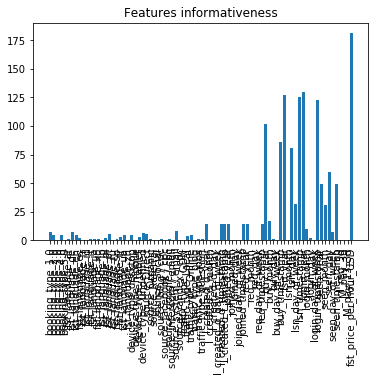

In [93]:
selector = SelectKBest(f_classif, k=10)
selector.fit(X, Y)

scores = -np.log10(selector.pvalues_)

plt.title('Features informativeness')
plt.bar(range(X.shape[1]), scores)
plt.xticks(range(X.shape[1]), train_df.columns, rotation='vertical')
plt.show()

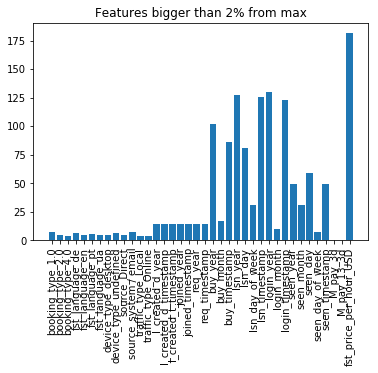

In [94]:
# Find 2% from max value
five_percent_max = np.max(scores[scores < np.inf]) * 0.02

filtered_scores = scores[scores > five_percent_max]
filtered_columns = train_df.columns[scores > five_percent_max]
plt.title('Features bigger than 2% from max')
plt.bar(range(filtered_scores.shape[0]), filtered_scores)
plt.xticks(range(filtered_scores.shape[0]), filtered_columns, rotation='vertical')
plt.show()

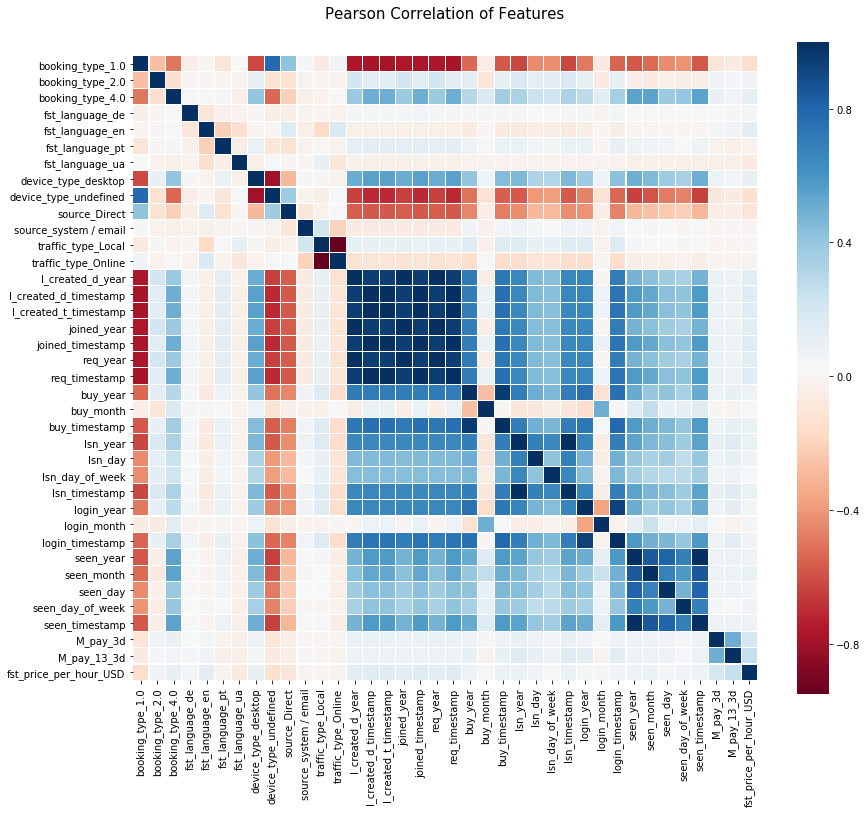

In [95]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.filter(filtered_columns).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white')

### Standardize features

In [107]:
features_std = [35, 36, 37]
for f in features_std:
    feature_sc = StandardScaler()
    X[:,f] = feature_sc.fit_transform(X[:,f].reshape(-1, 1)).reshape(X.shape[0])

## Model selection

1. Try with different hyperparameters
2. Try changing data (give all, give only the best, give best with one-hot encoding)

In [108]:
# Train-test split for accuracy metrics
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### Logistic regression (best = 73.4%)

In [109]:
log_reg_score = []
parameters = [1.0, 0.7, 0.4, 0.1, 0.01, 0.00001]

for c in parameters:
    log_reg = LogisticRegression(C=c)
    log_reg = log_reg.fit(X_train, y_train)
    pred = log_reg.predict(X_test)
    log_reg_score.append(accuracy_score(y_test, pred))

log_reg_score

[0.7340848806366048,
 0.7340848806366048,
 0.7340848806366048,
 0.7340848806366048,
 0.7340848806366048,
 0.7340848806366048]

### XGBoost (best = 87.1%)

In [110]:
# Start with different depth and learning rate
depth = [3, 5, 10]
learning_rates = [0.1, 0.01, 0.001]
scores = dict()

for d in depth:
    for alpha in learning_rates:
        xgb = XGBClassifier(silent=False, depth=d, learning_rate=alpha, seed=0)
        xgb = xgb.fit(X_train, y_train)
        pred = xgb.predict(X_test)
        scores[(d, alpha)] = accuracy_score(y_test, pred)

scores

C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-package

{(3, 0.001): 0.8614058355437666,
 (3, 0.01): 0.8622347480106101,
 (3, 0.1): 0.8706896551724138,
 (5, 0.001): 0.8614058355437666,
 (5, 0.01): 0.8622347480106101,
 (5, 0.1): 0.8706896551724138,
 (10, 0.001): 0.8614058355437666,
 (10, 0.01): 0.8622347480106101,
 (10, 0.1): 0.8706896551724138}

In [111]:
# Try with different number of estimators
xgb_lr = 0.1
depth = 3
n_estimators = [50, 100, 300, 1000]
scores = dict()

for n in n_estimators:
    xgb = XGBClassifier(silent=False, depth=depth, learning_rate=xgb_lr, seed=0)
    xgb = xgb.fit(X_train, y_train)
    pred = xgb.predict(X_test)
    scores[n] = accuracy_score(y_test, pred)
scores

C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-package

{50: 0.8706896551724138,
 100: 0.8706896551724138,
 300: 0.8706896551724138,
 1000: 0.8706896551724138}

### Adaboost (best = 87.1%)

In [112]:
depth = [3, 5, 10]
learning_rates = [0.1, 0.01, 0.001]
scores = dict()

for d in depth:
    for alpha in learning_rates:
        tree = DecisionTreeClassifier(criterion='gini', max_depth=d)
        adaboost = AdaBoostClassifier(base_estimator=tree, n_estimators=100, learning_rate=alpha, random_state=0)
        adaboost = adaboost.fit(X_train, y_train)
        pred = adaboost.predict(X_test)
        scores[(d, alpha)] = accuracy_score(y_test, pred)

scores

{(3, 0.001): 0.8635610079575596,
 (3, 0.01): 0.8630636604774535,
 (3, 0.1): 0.8708554376657824,
 (5, 0.001): 0.8660477453580901,
 (5, 0.01): 0.8688660477453581,
 (5, 0.1): 0.8678713527851459,
 (10, 0.001): 0.8481432360742706,
 (10, 0.01): 0.8665450928381963,
 (10, 0.1): 0.8688660477453581}

### Random Forest (best = 87.2%)

In [114]:
n_estimators = [250, 300, 350]
max_depth = [15, 20, 25]
scores = dict()

for d in max_depth:
    for n in n_estimators:
        random_forest = RandomForestClassifier(max_depth=d, n_estimators=n, random_state=0)
        random_forest = random_forest.fit(X_train, y_train)
        pred = random_forest.predict(X_test)
        scores[(d, n)] = accuracy_score(y_test, pred)

scores        

{(15, 250): 0.8711870026525199,
 (15, 300): 0.8696949602122016,
 (15, 350): 0.8701923076923077,
 (20, 250): 0.871684350132626,
 (20, 300): 0.871684350132626,
 (20, 350): 0.8710212201591512,
 (25, 250): 0.8706896551724138,
 (25, 300): 0.8698607427055703,
 (25, 350): 0.8693633952254642}

## AUC ROC

1. Random forest (mean fold = 94%)
2. Logistic regression (mean fold = 68%)
3. XGBoost (mean fold = 92%)
4. Adaboost (mean fold = 92%)

In [ ]:
# Prepare classifiers
classifier = RandomForestClassifier(max_depth=20, n_estimators=250, random_state=0)
#classifier = LogisticRegression(C=1.0)
#classifier = XGBClassifier(depth=5, learning_rate=0.1, seed=0)
#tree = DecisionTreeClassifier(criterion='gini', max_depth=3)
#classifier = AdaBoostClassifier(base_estimator=tree, n_estimators=100, learning_rate=0.1, random_state=0)
        

# K-fold
kfold = StratifiedKFold(n_splits=5)

tprs = list()
aucs = list()
mean_fpr = np.linspace(0, 1, 100)
i = 0

for train_dat, test_dat in kfold.split(X, Y):
    prob = classifier.fit(X[train_dat], Y[train_dat]).predict_proba(X[test_dat])
    
    # Thresholds: 0.001 - 0.5, 0.01 - 0.54, 0.1 - 0.8, 0.3 - 0.89, 0.5 - 0.92, 
    # 0.7 - 0.92, 0.9 - 0.92, 0.999 - 0.92, 1.2 - 0.92, 1.5 - 0.92 
    threshold_lst = [0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.999, 1.2, 1.5, 1]
    threshold = threshold_lst[10]
    prob[:,0] = prob[:,0]*threshold
    prob[:,1] = prob[:,1]*(1/threshold)
    prob[:,1] = np.minimum(1, prob[:,1])
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(Y[test_dat], prob[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating curve for random forest')
plt.legend(loc="lower right")
plt.show()